In [4]:
# Import useful libraries
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Choose model: SPM/SPMe/DFN
model = pybamm.lithium_ion.SPMe()
sim = pybamm.Simulation(model)
sim.solve([0, 3600])  # Solve for 1 hour
sim.plot()

ModuleNotFoundError: No module named 'ipywidgets'

In [6]:
# Select a pre-defined parameter set: https://docs.pybamm.org/en/latest/source/api/parameters/parameter_sets.html#bundled-parameter-sets
param = pybamm.ParameterValues("Chen2020")

# View the cited battery parameters
for k in param.keys():
    print(k, "=", param[k])

Ideal gas constant [J.K-1.mol-1] = 8.314462618
Faraday constant [C.mol-1] = 96485.33212
Boltzmann constant [J.K-1] = 1.380649e-23
Electron charge [C] = 1.602176634e-19
Ratio of lithium moles to SEI moles = 2.0
SEI partial molar volume [m3.mol-1] = 9.585e-05
SEI reaction exchange current density [A.m-2] = 1.5e-07
SEI resistivity [Ohm.m] = 200000.0
SEI solvent diffusivity [m2.s-1] = 2.5e-22
Bulk solvent concentration [mol.m-3] = 2636.0
SEI open-circuit potential [V] = 0.4
SEI electron conductivity [S.m-1] = 8.95e-14
SEI lithium interstitial diffusivity [m2.s-1] = 1e-20
Lithium interstitial reference concentration [mol.m-3] = 15.0
Initial SEI thickness [m] = 5e-09
EC initial concentration in electrolyte [mol.m-3] = 4541.0
EC diffusivity [m2.s-1] = 2e-18
SEI kinetic rate constant [m.s-1] = 1e-12
SEI growth activation energy [J.mol-1] = 0.0
Negative electrode reaction-driven LAM factor [m3.mol-1] = 0.0
Positive electrode reaction-driven LAM factor [m3.mol-1] = 0.0
Negative current collector

In [7]:
# Modify a specific parameter
param.update({
    "SEI growth activation energy [J.mol-1]": 0.05,
    "Initial SEI thickness [m]": 1e-8,
})

# View the parameters after modification
for k in param.keys():
    print(k, "=", param[k])

Ideal gas constant [J.K-1.mol-1] = 8.314462618
Faraday constant [C.mol-1] = 96485.33212
Boltzmann constant [J.K-1] = 1.380649e-23
Electron charge [C] = 1.602176634e-19
Ratio of lithium moles to SEI moles = 2.0
SEI partial molar volume [m3.mol-1] = 9.585e-05
SEI reaction exchange current density [A.m-2] = 1.5e-07
SEI resistivity [Ohm.m] = 200000.0
SEI solvent diffusivity [m2.s-1] = 2.5e-22
Bulk solvent concentration [mol.m-3] = 2636.0
SEI open-circuit potential [V] = 0.4
SEI electron conductivity [S.m-1] = 8.95e-14
SEI lithium interstitial diffusivity [m2.s-1] = 1e-20
Lithium interstitial reference concentration [mol.m-3] = 15.0
Initial SEI thickness [m] = 1e-08
EC initial concentration in electrolyte [mol.m-3] = 4541.0
EC diffusivity [m2.s-1] = 2e-18
SEI kinetic rate constant [m.s-1] = 1e-12
SEI growth activation energy [J.mol-1] = 0.05
Negative electrode reaction-driven LAM factor [m3.mol-1] = 0.0
Positive electrode reaction-driven LAM factor [m3.mol-1] = 0.0
Negative current collecto

In [8]:
# Choose a model that includes SEI, otherwise SEI won't grow
model = pybamm.lithium_ion.DFN(
    options={
        "SEI": "reaction limited",
        "SEI porosity change": "true",
    }
)

In [9]:
# Specify a faster solver if available (optional)
try:
    solver = pybamm.IDAKLUSolver()
except Exception:
    solver = pybamm.CasadiSolver()

In [10]:
# Define experiment protocol: 1C discharge/charge, repeated 500 cycles
n_cycles = 500
one_cycle = [
    "Discharge at 1C until 2.7 V",
    "Rest for 1 hour",
    "Charge at 1C until 4.2 V",
    "Rest for 1 hour",
]
experiment = pybamm.Experiment(one_cycle * n_cycles)

In [11]:
# Run the simulation with updated parameters and defined experiment
sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment, solver=solver)
sol = sim.solve()

In [12]:
# Check the variables in the model
var_names = list(model.variables.keys())
print(len(var_names))
print(var_names)

# Find anything SEI-related
sei_vars = [n for n in var_names if "sei thickness" in n.lower()]   # find specific variables
print("\nTotal variables found:", len(sei_vars))    # number of found variables
print(*sei_vars, sep="\n")   # print all found variables

cycle_vars = [n for n in var_names if "number" in n.lower()]   # find specific variables
print("\nTotal cycle variables found:", len(cycle_vars))    # number of found variables
print(*cycle_vars, sep="\n")   # print all found variables

512
['Time [s]', 'Time [min]', 'Time [h]', 'x [m]', 'x_n [m]', 'x_s [m]', 'x_p [m]', 'r_n [m]', 'r_p [m]', 'Current variable [A]', 'Total current density [A.m-2]', 'Current [A]', 'C-rate', 'Discharge capacity [A.h]', 'Throughput capacity [A.h]', 'Discharge energy [W.h]', 'Throughput energy [W.h]', 'Negative electrode interface utilisation variable', 'X-averaged negative electrode interface utilisation variable', 'Negative electrode interface utilisation', 'X-averaged negative electrode interface utilisation', 'Positive electrode interface utilisation variable', 'X-averaged positive electrode interface utilisation variable', 'Positive electrode interface utilisation', 'X-averaged positive electrode interface utilisation', 'Negative particle crack length [m]', 'X-averaged negative particle crack length [m]', 'Negative particle cracking rate [m.s-1]', 'X-averaged negative particle cracking rate [m.s-1]', 'Positive particle crack length [m]', 'X-averaged positive particle crack length [m]'

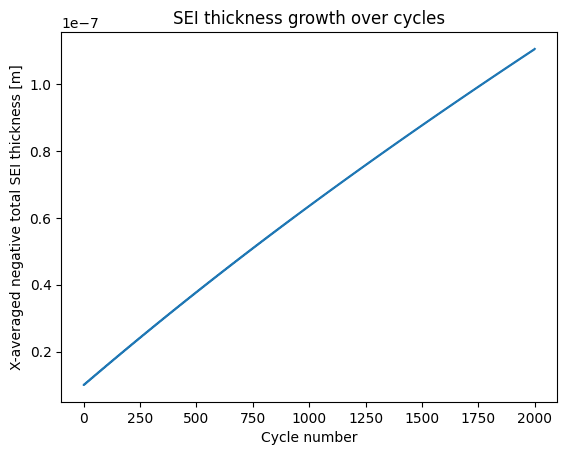

In [15]:

# Plot SEI thickness at end of each cycle
sei_var = "X-averaged negative total SEI thickness [m]"  # recommended

sei_end = np.array([float(cyc[sei_var].entries[-1]) for cyc in sol.cycles])
cycles = np.arange(1, len(sei_end) + 1)

plt.figure()
plt.plot(cycles, sei_end)
plt.xlabel("Cycle number")
plt.ylabel(sei_var)
plt.title("SEI thickness growth over cycles")
plt.show()